## House Price Prediciton

    Problem statement: Predict house price given many features which describe house condition and residential area
    Type: Regression
    Performance metric: RMSE

    What I did in notebook:
    1. Data pre-processing: (a) Fill missing value, (b) make sure data type is correct
    2. Feature engineering: (a) Combine features, (b) convert to log-scale, (c) one-hot encoding
    3. Modelling: (a) K-fold validation, (b) create several models, (c) Grid-Search

### Data Pre-Processing

In [1]:
# Library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
from sklearn.preprocessing import minmax_scale # min-max normalization
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import RidgeCV # ridge regularization
from sklearn.linear_model import LassoCV # lasso regularization
from sklearn.tree import DecisionTreeRegressor # decision tree
from sklearn.ensemble import RandomForestRegressor # random forest
from sklearn.model_selection import StratifiedKFold # Stratified K-Fold for cross-validation
from sklearn.model_selection import KFold # Stratified K-Fold for cross-validation
from sklearn.model_selection import GridSearchCV # to perform Grid search cross-validation 
from sklearn.model_selection import cross_val_score # to calculate cross-validation score
from sklearn.metrics import mean_squared_error # to calculate performance metric
import time
from datetime import datetime

In [2]:
# Read file
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

# From this file, the target (Y) is SalePrice column
# Ideally we separate target (Y) and predictors (X), before that let see a bit summary of train.csv and test.csv

In [3]:
# Get sense in train dataset
train.describe()

# Several columns don't have complete value

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
# Get sense in test dataset
test.describe()

# Several columns don't have complete value

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1381.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,437.260486,442.898624,398.165820,420.610226,44.043251,485.566099,0.530648,0.252468,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,26.431175,0.775945,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.00000,1959.000000,1.000000,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1079.000000,0.000000,0.000000,1432.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,0.00000,1979.000000,2.000000,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,1382.500000,676.000000,0.000000,1721.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.00000,2002.000000,2.000000,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,5095.000000,1862.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,6.000000,2.000000,15.000000,4.00000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


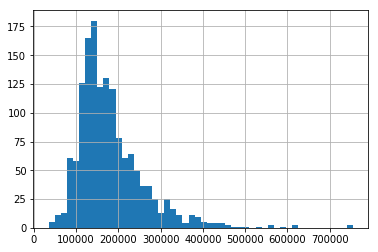

In [5]:
# Get sense in target distribution
original_y = train['SalePrice'].reset_index(drop=True) # will be used as comparison on performance
train['SalePrice'].hist(bins = 50)

# Right-skewed distribution

What we will do after get sense in train, test dataset, and also target (SalePrice) distribution.
1. Create normally distributed of Target using log
2. Fill missing value

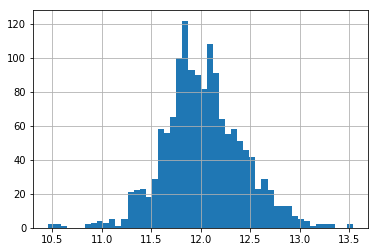

In [6]:
# Using Log to create normally distributed SalePrice
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
train['SalePrice'].hist(bins = 50)

# Create separate data frame of target (Y)
y = train['SalePrice'].reset_index(drop=True)

In [7]:
# Concat train and test dataset before handling missing value
# Drop unecessary column

train = train.drop(['Id', 'SalePrice'], axis=1) # ID dont have meaning for predicting SalePrice
test = test.drop(['Id'], axis=1)

# Create separte data frame of predictors (X)
x = pd.concat([train, test]).reset_index(drop=True)
x.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [8]:
# Handling missing value

x.info()
# PoolQC has 2909 missing value
# MiscFeature has 2814 missing value
# Alley has 2721 missing value
# Fence has 2348 missing value
# FireplaceQu has 1420 missing value
# LotFrontage has 227 missing value
# GarageYrBlt, GarageFinish, GarageQual, GarageCond have 159 missing value
# GarageType has 157 missing value
# BsmtCond, BsmtExposure have 82 missing value
# GarageYrBlt, BsmtQual has 81 missing value
# BsmtFinType2 has 80 missing value
# BsmtFinType1 has 79 missing value
# MasVnrArea has 23 missing value
# MasVnrType has 24 missing value
# BsmtFullBath, BsmtHalfBath, Utilities, Functional has 2 missing value
# SaleType, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF have 1 missing value 
# Exterior1st, Exterior2nd, Electrical, KitchenQual  have 1 missing value
# GarageCars, GarageArea have 1 missing value


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non

In [9]:
# Convert from numeric to categorical value
x['MSSubClass'] = x['MSSubClass'].apply(str)
x['YrSold'] = x['YrSold'].astype(str)
x['MoSold'] = x['MoSold'].astype(str)

# Fill these columns with suitable value
x['Functional'] = x['Functional'].fillna('Typ') 
x['Electrical'] = x['Electrical'].fillna("SBrkr") 
x['KitchenQual'] = x['KitchenQual'].fillna("TA") 

# Filling these with MODE , i.e. , the most frequent value in these columns .
x['Exterior1st'] = x['Exterior1st'].fillna(x['Exterior1st'].mode()[0]) 
x['Exterior2nd'] = x['Exterior2nd'].fillna(x['Exterior2nd'].mode()[0])
x['SaleType'] = x['SaleType'].fillna(x['SaleType'].mode()[0])
x['MasVnrArea'] = x['MasVnrArea'].fillna(x['MasVnrArea'].mode()[0])


# Filling LotFrontage
x['LotFrontage'] = x.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Missing value in Garage-related columns most probably because the house doesnt have Garage.
# Numeric columns will be replaced with 0. Categorical columns will be replaced with 'None'
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    x[col] = x[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    x[col] = x[col].fillna('None')

# Missing value in Basement-related column most probably because the house doesnt have Basement. 
# Numeric columns will be replaced with 0. Categorical columns will be replaced with 'None'
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath' ):
    x[col] = x[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    x[col] = x[col].fillna('None')
    
# Other missing value in categorical columns will be replaced with 'None'
objects = []
for i in x.columns:
    if x[i].dtype == object:
        objects.append(i)
x.update(x[objects].fillna('None'))

# Other missing value in numeric columns will be replaced with 0.
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in x.columns:
    if x[i].dtype in numeric_dtypes:
        numerics.append(i)
x.update(x[numerics].fillna(0))
# Interesting feature need EDA 'LotFrontage', Mas Vnr Area

x.info()
# Each predictors have the 2919 value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
MSSubClass       2919 non-null object
MSZoning         2919 non-null object
LotFrontage      2919 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            2919 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2919 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2919 non-null object
Exterior2nd      2919 n

### Feature Engineering

In [10]:
# Create new features
# Total square feet of house
x['total_sf'] = (x['TotalBsmtSF'] + x['BsmtFinSF1'] + x['BsmtFinSF2'] +
                                 x['1stFlrSF'] + x['2ndFlrSF'])
# Total bathrooms
x['total_bathrooms'] = (x['FullBath'] + (0.5 * x['HalfBath']) +
                               x['BsmtFullBath'] + (0.5 * x['BsmtHalfBath']))
# Total porchs
x['total_porch_sf'] = (x['OpenPorchSF'] + x['3SsnPorch'] +
                              x['EnclosedPorch'] + x['ScreenPorch'] +
                              x['WoodDeckSF'])
# Boolean features
# if value feature > 0 then it'll has flag 1
x['hasPool'] = x['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
x['has2ndFloor'] = x['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
x['hasGarage'] = x['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
x['hasBasement'] = x['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
x['hasFireplace'] = x['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

x.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,total_sf,total_bathrooms,total_porch_sf,hasPool,has2ndFloor,hasGarage,hasBasement,hasFireplace
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,69.542994,10168.114080,6.089072,5.564577,1971.312778,1984.264474,101.396026,441.272011,49.565262,560.579993,1051.417266,1159.581706,336.483727,4.694416,1500.759849,0.429599,0.061322,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1870.364166,1.766016,472.712573,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,3038.319973,2.218397,182.959575,0.004454,0.428571,0.945872,0.972936,0.513532
std,21.703256,7886.996359,1.409947,1.113131,30.291442,20.894344,178.854579,455.606014,169.179104,439.590889,441.120498,392.362079,428.701456,46.396825,506.051045,0.524676,0.245608,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,449.686321,0.762196,215.535686,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,1096.631734,0.808840,160.021404,0.066598,0.494956,0.226309,0.162298,0.499902
min,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2342.500000,1.500000,48.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,70.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,467.000000,989.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2870.000000,2.000000,164.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,163.500000,733.000000,0.000000,805.000000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3558.000000,2.500000,266.500000,0.000000,1.000000,1.000000,1.000000,1.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,17396.000000,7.000000,1424.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Handling Numeric Feature

In [11]:
# Many numeric features have different range of values
# It might confuse the algorithm, so we will do normalization to numeric feature
# MinMax normalization

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = []

for i in x.columns:
    if x[i].dtype in numeric_dtypes:
        numeric_columns.append(i)

x_normalized = x
x_normalized[numeric_columns] = minmax_scale(x[numeric_columns], feature_range=(0, 1))

# Separate dataset in order to measure effort performance
x_train_1 = x.iloc[:len(y), :]
x_test_1 = x.iloc[len(y):, :]

x_normalized[numeric_columns].describe() # predictors X now on the same scale

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,total_sf,total_bathrooms,total_porch_sf,hasPool,has2ndFloor,hasGarage,hasBasement,hasFireplace
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,0.166243,0.041450,0.565452,0.570572,0.719658,0.571075,0.063373,0.078184,0.032481,0.239974,0.172081,0.173405,0.162946,0.004412,0.219812,0.143200,0.030661,0.392001,0.190134,0.357528,0.348179,0.342425,0.149281,0.847469,0.353203,0.317683,0.065807,0.063998,0.022824,0.005123,0.027886,0.002815,0.002990,0.158500,0.203066,0.128483,0.004454,0.428571,0.945872,0.972936,0.513532
std,0.074326,0.036865,0.156661,0.139141,0.219503,0.348239,0.111784,0.080724,0.110864,0.188181,0.072196,0.082412,0.207604,0.043606,0.095337,0.174892,0.122804,0.138242,0.251436,0.102837,0.071487,0.120721,0.161532,0.203755,0.152439,0.144849,0.088853,0.091072,0.063482,0.049583,0.097542,0.044580,0.033377,0.064273,0.134807,0.112375,0.066598,0.494956,0.226309,0.162298,0.499902
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133562,0.028877,0.444444,0.500000,0.590580,0.250000,0.000000,0.000000,0.000000,0.094178,0.129787,0.113842,0.000000,0.000000,0.149209,0.000000,0.000000,0.250000,0.000000,0.250000,0.333333,0.230769,0.000000,0.886724,0.200000,0.215054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117718,0.083333,0.033708,0.000000,0.000000,1.000000,1.000000,0.000000
50%,0.167808,0.038108,0.555556,0.500000,0.731884,0.716667,0.000000,0.065202,0.000000,0.199914,0.161866,0.157110,0.000000,0.000000,0.209118,0.000000,0.000000,0.500000,0.000000,0.375000,0.333333,0.307692,0.250000,0.895786,0.400000,0.322581,0.000000,0.035040,0.000000,0.000000,0.000000,0.000000,0.000000,0.148634,0.166667,0.115169,0.000000,0.000000,1.000000,1.000000,1.000000
75%,0.202055,0.048003,0.666667,0.625000,0.934783,0.900000,0.102188,0.129872,0.000000,0.344606,0.213093,0.221277,0.340920,0.000000,0.265543,0.333333,0.000000,0.500000,0.500000,0.375000,0.333333,0.384615,0.250000,0.906661,0.400000,0.387097,0.117978,0.094340,0.000000,0.000000,0.000000,0.000000,0.000000,0.188958,0.250000,0.187149,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


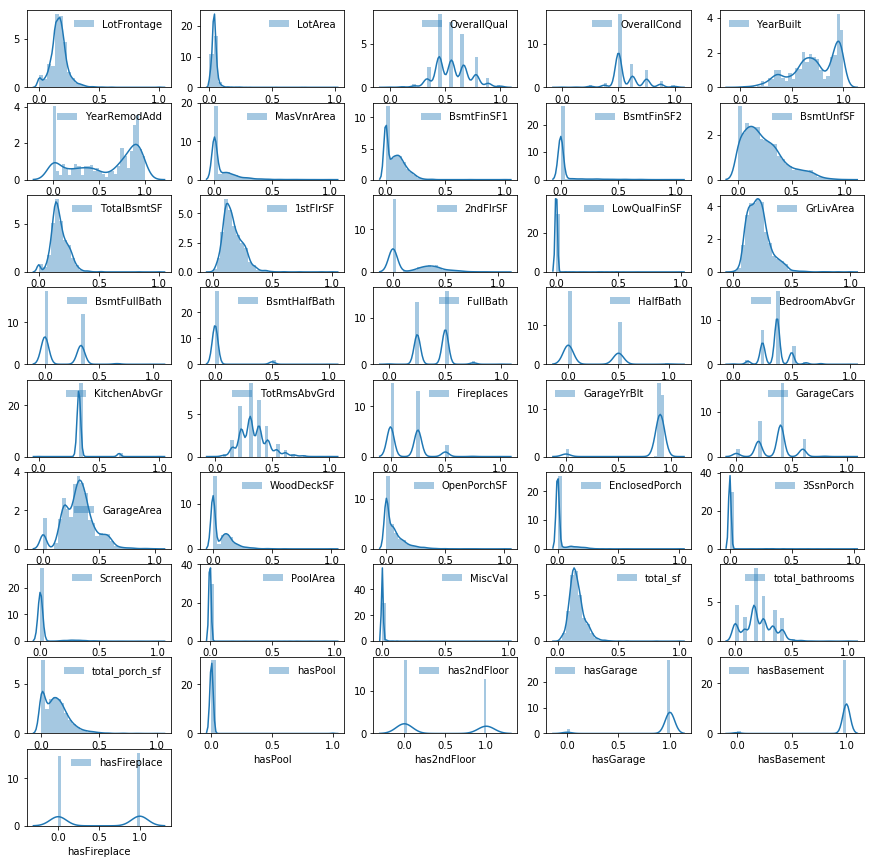

In [12]:
# See distribution in numeric features

# Define how many plots along and across
ncols = 5
nrows = int(np.ceil(len(x_normalized[numeric_columns].columns) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

# Counter, so we can remove unwated axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(x_normalized[numeric_columns].columns):

            ax = sns.distplot(x_normalized[x_normalized[numeric_columns].columns[counter]], bins=30, ax=axes[i,j], label = x_normalized[numeric_columns].columns[counter] )
            leg = ax.legend(loc='best')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1
plt.show() 

### Handling Categorical Feature

In [13]:
# Several algorithm could not handle string value, so we should transform it into numeric value
# One of method is to create one-hot encoding
# It will create dummy column which represent category value in binary

categorical_columns = []

for i in x.columns:
    if x[i].dtype == object:
        categorical_columns.append(i)

x_train_1 = x.iloc[:len(y), :]
        
x_final = x_normalized
x_final = pd.get_dummies(x_normalized[categorical_columns]).reset_index(drop=True)
x_final.shape # get 301 features

# Separate dataset in order to measure effort performance
x_train_2 = x_normalized.iloc[:len(y), :]
x_test_2 = x_normalized.iloc[len(y):, :]

### Modelling

In [14]:
# Before input our predictors to machine learning algorithm, we will split back train and test dataset

x_train = x_final.iloc[:len(y), :]
x_test = x_final.iloc[len(y):, :]
x_train.shape, y.shape, x_test.shape

((1460, 301), (1460,), (1459, 301))

We will use several models to solve regression problem, and compare which one has better performance (RMSE). Several models are (a) Ridge regression, (b) Lasso regression, (c) Decision tree, (d) Random forest

In [15]:
# In order to get estimation of our performance in Test dataset, we will use cross-validation
# We will split train dataset into 5 and do cross-validation

# Stratified k-fold being used in order to get stratified split
kfolds = KFold(n_splits=5, random_state=41)

# For the sake of simplicity measuring performance metric (RMSE)
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=x_train):
    rmse = np.sqrt(-cross_val_score(model, X, y, cv=kfolds, scoring="neg_mean_squared_error"))
    return (rmse)    

In [16]:
# Function to get best Random Forest model using Grid-Search
def rf_grid_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'n_estimators': (50, 100, 1000),
            'min_samples_split': (2, 3),
            'max_features': (1, 5, 10)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(n_estimators=best_params["n_estimators"],
                                min_samples_split=best_params['min_samples_split'], max_features=best_params['max_features'],
                                random_state=False, verbose=False)
    return rfr

# Function to get best Decision Tree model using Grid-Search
def dt_grid_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=DecisionTreeRegressor(),
        param_grid={
            'min_samples_split': (2, 3),
            'max_features': (1, 5, 10)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    dtr = DecisionTreeRegressor( min_samples_split=best_params['min_samples_split'], max_features=best_params['max_features'],
                                random_state=False)
    return dtr

In [17]:
# Define models

ridge_reg = RidgeCV(alphas = [1e-3, 1e-2, 1e-1, 1, 10, 15, 20], cv = kfolds)
lasso_reg = LassoCV(alphas = [5e-05,0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006], cv = kfolds)
tree_reg = DecisionTreeRegressor()
forest_reg = RandomForestRegressor()
tree_grid_reg = dt_grid_model(x_train, y)
forest_grid_reg = rf_grid_model(x_train, y)
tree_grid_reg_numeric = dt_grid_model(x_train_2[numerics], y) # Decision Tree only numeric
forest_grid_reg_numeric = rf_grid_model(x_train_2[numerics], y) # Random Forest only numeric


/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [18]:
# Get cross-validation score in several models

score = cv_rmse(ridge_reg , x_train)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso_reg , x_train)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(tree_reg , x_train)
print("DECISION TREE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(forest_reg , x_train)
print("RANDOM FOREST: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(tree_grid_reg , x_train)
print("SearchGrid - DECISION TREE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(forest_grid_reg , x_train)
print("SearchGrid - RANDOM FOREST: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(tree_grid_reg_numeric , x_train_2[numerics])
print("SearchGrid 2 - DECISION TREE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(forest_grid_reg_numeric , x_train_2[numerics])
print("SearchGrid 2 - RANDOM FOREST: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


RIDGE: 0.1736 (0.0117)
 2019-06-23 12:26:06.376161


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025590882580925012, tolerance: 0.015531757542978093
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020443814090878476, tolerance: 0.014491631155835854
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04068491865331936, tolerance: 0.014491631155835854
  tol, rng, random, positive)


LASSO: 0.1730 (0.0116)
 2019-06-23 12:26:09.307482
DECISION TREE: 0.2523 (0.0193)
 2019-06-23 12:26:09.537085


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

RANDOM FOREST: 0.1941 (0.0180)
 2019-06-23 12:26:10.673930
SearchGrid - DECISION TREE: 0.3258 (0.0049)
 2019-06-23 12:26:10.709659
SearchGrid - RANDOM FOREST: 0.1961 (0.0144)
 2019-06-23 12:26:11.434550
SearchGrid 2 - DECISION TREE: 0.2314 (0.0092)
 2019-06-23 12:26:11.480761
SearchGrid 2 - RANDOM FOREST: 0.1405 (0.0085)
 2019-06-23 12:26:33.717182


In [19]:
# Best RMSE performance LASSO: 0.1730
lasso_reg.fit(x_train,y)

# Result submission
print('Predict submission')
submission = pd.read_csv("../input/sample_submission.csv")
# Do Expm 1 to convert Log1pm for submission
submission.iloc[:,1] = (np.expm1(lasso_reg.predict(x_test)))
submission.to_csv("submission.csv", index=False)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019567524584712004, tolerance: 0.019008081403702633
  tol, rng, random, positive)


Predict submission


In [20]:
# Measurement in effort
# We will see impact of our effort using RMSE on training data
# List of major activity in this notebook are: (1) change target to log-scale, (2) normalization, and (3) one-hot encoding
# Using Lasso as algorithm to compare these efforts

# original_y - Y before transformed into log
# x -> original X
# x_normalized -> Normalized X
# x_final -> Transform one-hot encoding X

x_train_1.shape, x_train_2.shape, x_train.shape, x_test_1.shape, x_test_2.shape, x_test.shape

((1460, 87), (1460, 87), (1460, 301), (1459, 87), (1459, 87), (1459, 301))

In [21]:
# Original Target could be used as original_y
lasso_reg.fit(x_train,original_y)
y_predicted = lasso_reg.predict(x_train)
original_y_rmse = rmsle(original_y, y_predicted) # RMSE on training data = 29242.86277804366
# original_y_rmse

# Before Normalized X
# Only include numeric features
lasso_reg.fit(x_train_1[numerics],y)
y_predicted = lasso_reg.predict(x_train_1[numerics])
original_x_rmse = rmsle(y, y_predicted) # RMSE on training data = 0.14708380182717076

# Normalized X
lasso_reg.fit(x_train_2[numerics],y)
y_predicted = lasso_reg.predict(x_train_2[numerics])
normalized_x_rmse = rmsle(y, y_predicted) # RMSE on training data = 0.14708380182717076

# Print
print("RMSE Original Y on Training Data")
print(original_y_rmse)

print("\nRMSE Original X on Training Data")
print(original_x_rmse)

print("\nRMSE Normalized X on Training Data")
print(normalized_x_rmse)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206995443118.38397, tolerance: 759214014.2531197
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206992659269.6261, tolerance: 759214014.2531197
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206992212252.8125, tolerance: 759214014.2531197
  tol, rng, random, positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase 

RMSE Original Y on Training Data
29242.86277804366

RMSE Original X on Training Data
0.14708380182717076

RMSE Normalized X on Training Data
0.14708380182717076


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303307279311.7953, tolerance: 920791133.4609975
  positive)


In [22]:
# It turns out Only normalized predictors without one-hot encoding perform better in this dataset
# Do re-submission using only Normalized-Numeric-Features
print('Predict submission')
submission2 = pd.read_csv("../input/sample_submission.csv")
# Do Expm 1 to convert Log1pm for submission
lasso_reg.fit(x_train_2[numerics],y)
submission2.iloc[:,1] = (np.expm1(lasso_reg.predict(x_test_2[numerics])))
submission2.to_csv("submission2.csv", index=False)

Predict submission


### Edit 2019-06-23
Using only numeric features and do GridSearch Cross-Validation in Decision Tree and Random Forest. Turns out new Random Forest model outperform Lasso model before

In [23]:
# Best estimated result of RMSE is 0.1409
# Random Forest with only Numeric Features perform better than others model

# Fit Random Forest model
forest_grid_reg_numeric.fit(x_train_2[numerics],y)
y_predicted = forest_grid_reg_numeric.predict(x_train_2[numerics])

print("RMSE on Training Data")
print(rmsle(y, y_predicted))
# RMSE on training data = 0.05478232174503214

RMSE on Training Data
0.051446124017732894


In [24]:
# Result re-submission 3
print('Predict submission')
submission3 = pd.read_csv("../input/sample_submission.csv")
# Do Expm 1 to convert Log1pm for submission
submission3.iloc[:,1] = (np.expm1(forest_grid_reg_numeric.predict(x_test_2[numerics])))
submission3.to_csv("submission3.csv", index=False)

Predict submission
